# Exercise Sheet 8: Generative Adversarial Networks

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.manifold import TSNE
import torchvision
import torchvision.utils as vutils
from torchvision import datasets, transforms
from torch.nn.utils import spectral_norm
from torch.utils.data import DataLoader

%pip install einops
from einops import rearrange

import os
import numpy as np
import random
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
# folder path
data_path = './data'
model_path = './model'
result_path = './results'

# random seed np/torch
seed = 42
random.seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create folder if not exist
if not os.path.exists(data_path):
    os.makedirs(data_path)
if not os.path.exists(model_path):
    os.makedirs(model_path)
if not os.path.exists(result_path):
    os.makedirs(result_path)

## Task 1 a): Derive Optimal Discriminator D*

Use equation (1) as a starting point to derive the optimal discriminator D∗ in terms of data probability $p_data (x)$ and generator probability $p_G(x)$.
Assume generator G is fixed.

The objective function V(D,G) is:

\begin{align}
V(D,G) = \mathbb{E}{x \sim p{data}(x)} [\log D(x)] + \mathbb{E}_{z \sim p(z)} [\log (1 - D(G(z)))]
\end{align}

\begin{align}
D* = argmax V(D,G)
\end{align}

\begin{align}
G* = argmin V(D,G)
\end{align}


It is formulated as a minmax game, where the Discriminator is trying to maximize its reward V(D,G) and the Generator is trying to minimize the Discriminator's reward (or maximize its loss).
The first term represents the expected value of $logD(x)$ over the real data distribution $p_{data}(x)$, while the second term represents the expected value of $log(1−D(G(z)))$ over the generated data distribution p_g(z), where z is a random noise vector sampled from a distribution $p(z)$.


(1) Rewriting the objective function in terms of $p_{data}(x)$ and $p_z(x)$ by replacing the expectation with integrals (standard formulation for continuous random variables):<br>

* For the first term we can rewrite the expectation as an integral over $p_{data}(x)$:
\begin{align}
\mathbb{E}{x \sim p{data}(x)} [\log D(x)] = \int p_{data}(x) \log D(x) dx
\end{align}

* For the second term we can rewrite the expectation as an integral over $p_g(z)$:

\begin{align}
\mathbb{E}_{z \sim p(z)} [\log (1 - D(G(z)))] = \int p_g(z) \log (1 - D(G(z))) dz
\end{align}

* To express the second term in terms of $p_g(x)$ we can perform a change of variables using the fact that $x=G(z)$. Thereby, det is a determinant of the Jacobian matrix of the inverse function $G^{-1}(x)$. By the change of the formaula:
  
\begin{align}
p_g(x) = p_g(z) \left|\det \frac{\partial G^{-1}(x)}{\partial x}\right|
\end{align}

* Now substituting this expression for $p_g(z)$ into the second term we get:$
  
\begin{align}
\int p_g(z) \log (1 - D(G(z))) dz &= \\
 \int p_g(x) \log (1 - D(x)) \left|\det \frac{\partial G^{-1}(x)}{\partial x}\right| dx
&= \\ \int p_g(x) \log (1 - D(x)) dx
\end{align}

* Combining those terms we obtain the objective function:

\begin{align}
V(D,G) &= \int p_{data}(x) \times \log D(x) dx + \int p_g(x) \times \log(1 - D(x)) dx
\end{align}

(2) Finding the optimal discriminator $D^{*}$. Taking the derivative of the value function $V$ with respect to $D(x)$ and setting it to zero:

\begin{align}
\frac{\delta V}{\delta D(x)} = \frac{p_{data}(x)}{D(x)} - \frac{p_g(x)}{1 - D(x)} = 0
\end{align}

Solving for D*(x):

\begin{align}
\frac{p_{data}(x)}{D(x)} &= \frac{p_g(x)}{1 - D(x)} \\
p_{data}(x) (1 - D(x)) &= p_g(x) D(x) \\
p_{data}(x) - p_{data}(x) D(x) &= p_g(x) D(x) \\
p_{data}(x) &= p_{data}(x) D(x) + p_g(x) D(x) \\
D(x) (p_{data}(x) + p_g(x)) &= p_{data}(x) \\
D(x) &= \frac{p_{data}(x)}{p_{data}(x) + p_g(x)}
\end{align}


\begin{align}
D_G^*(x) = \frac{p_{data}(x)}{p_{data}(x) + p_g(x)}
\end{align}

## Task 1 b): Find Optimal Generator $G*$

**Use the obtained D∗ to find the optimal point minimizing V.**

Using the optimal discriminator D*:
\begin{align}
D_G^*(x) = \frac{p_{data}(x)}{p_{data}(x) + p_g(x)}
\end{align}

(1) We can substitute this back into the original objective function $V(D,G)$:

\begin{align}
V(D^*,G) &= \mathbb{E}_{x \sim p_{\text{data}}(x)} [\log D^*(x)] + \mathbb{E}_{x \sim p_g(x)} [\log (1 - D^*(x))] \\[10pt]

&= \int p_{data}(x) \times \log D(x) dx + \int p_g(x) \times \log(1 - D(x)) dx \\[10pt]

&= \int p_{\text{data}}(x) \log \left(\frac{p_{\text{data}}(x)}{p_{\text{data}}(x) + p_g(x)}\right) dx + \int p_g(x) \log \left(\frac{p_g(x)}{p_{\text{data}}(x) + p_g(x)}\right) dx
\end{align}

(2) The optimal point minimizing V occurs when $p_g(x) = p_{data}(x)$. Next, substitute this condition into the previously defined optimal discriminator function:

\begin{align}
D_G^*(x) &= \frac{p_{\text{data}}(x)}{p_{\text{data}}(x) + p_g(x)} \\[10pt]
&= \frac{p_{\text{data}}(x)}{p_{\text{data}}(x) + p_{\text{data}}(x)} \quad \text{(because } p_g(x) = p_{\text{data}}(x) \text{)} \\[10pt]
&= \frac{p_{\text{data}}(x)}{2p_{\text{data}}(x)} \\[10pt]
&= \frac{1}{2}
\end{align}


(3) In this case for G fixed the optimal discriminator D is:


\begin{align}
D_G^*(x) = \frac{p_{data}(x)}{p_{data}(x) + p_{data}(x)} = \frac{1}{2}
\end{align}

**What value does D∗have at this point and what would this value imply?**
<br>
The Nash Equilibrium of the Min-Max Game is achieved when:
* When $D*(x) = 1/2$, it means that the discriminator can't distinguish between real and generated samples. It assigns equal probability (50%) to both real and generated data.
* This occurs when the generator has perfectly mimicked the real data distribution, i.e., $p_g(x) = p_{data}(x)$ and the discriminator cannot distinguish real from fake data.

\begin{align}
V(D,G) = \mathbb{E}{x \sim p{data}(x)} [\log D(x)] + \mathbb{E}_{z \sim p(z)} [\log (1 - D(G(z)))]
\end{align}

Substituting D*(x) = 1/2 into the objective function:<br>

\begin{align}
V(D^*,G) &= \log(1/2) + \log(1/2) = -\log(4)
\end{align}
This is the global minimum of the objective function.

## Task 2: Training a GAN

* Use Adam optimizer with a learning rate of 0.0001 and β1 = 0.5.
* Fashion-MNIST has a standard resolution of 28 × 28 so make sure to resize it to 32 × 32
* You may have to adapt the DCGAN architecture slightly to generate 32×32 images instead of 64 × 64
* Using spectral normalization on the weights of the Discriminator can help with mode collapse and make training more stable
* You should already see decent results after a couple of epochs.

In [15]:
# hyperparameters
config_dict = {
    'img_size': 32,
    'latent_dim': 100,
    'batch_size': 128,
    'num_epochs': 5,
    'lr': 1e-4,
    'momentum': 0.5,
    'betas': (0.5, 0.999)
}

## Seminal Paper - Generative Adversarial Nets

General details and background:
* simultaneous training of two models <br>
  (1) Discriminator, which estimates the probability that a sample came from the training data rather then from the Generator  <br>
  (2) Generator, which captures the distribution <br>
* represent a probability distribution over the data observed

Training procesure: MinMax two-player game
* G: maximize probability of D making a mistake
* D: maximizing the probability to correctly estimate if a sample came from the Generator

Equillibrium:
* G recovering the true training data distribution
* D equals to 1/2 everywhere

In [16]:
# Download Fashion MNIST dataset
mean = (0.5)
std = (0.5)

# Define a transform to normalize the data
transform_train = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(5),
                                transforms.Resize((config_dict['img_size'])),
                                transforms.Normalize(mean, std)
                                ])

transform_test = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize((config_dict['img_size'])),
                                transforms.Normalize(mean, std)
                                ])

# Download and load the training data
trainset = datasets.FashionMNIST(data_path, download=True, train=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=config_dict['batch_size'], shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST(data_path, download=True, train=False, transform=transform_test)
testloader = DataLoader(trainset, batch_size=config_dict['batch_size'], shuffle=True)

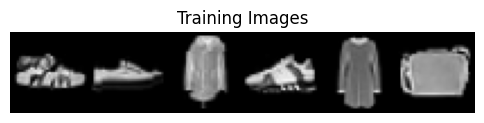

In [17]:
# Get a batch of real images
real_batch = next(iter(trainloader))
images, _ = real_batch

# Normalize the images to [0, 1] range for plotting
images = (images + 1) / 2

# Transpose the grid to match the expected shape for imshow
grid = torchvision.utils.make_grid(images[:6], padding=2, normalize=False)
grid = np.transpose(grid.cpu().numpy(), (1, 2, 0))

# Plot the grid of images
plt.figure(figsize=(6, 4))
plt.axis("off")
plt.title("Training Images")
plt.imshow(grid)
plt.savefig(os.path.join(result_path, 'training_images.png'))
plt.show()


## Task 2: Training a GAN

In [18]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [19]:
class Generator(nn.Module):
    """ Generator architecture """
    def __init__(self, z_channels=100,  nf=64, embed_dim=32, num_classes=10, out_channels=1, class_cond=True):
        super(Generator, self).__init__()
        self.num_classes = num_classes
        self.latent_dim = z_channels
        self.class_cond = class_cond
        self.nf = nf

        if self.class_cond:
            self.embedding = nn.Embedding(num_classes, embed_dim) # class embeddings
        else:
            embed_dim = 0


        # fully connected input layer
        self.fc = nn.Linear(z_channels + embed_dim, 4*4*nf*8) # out: 132 x 8192
        self.bn = nn.BatchNorm2d(4*4*nf*8)

        # Convolutional layers
        # resource: https://distill.pub/2016/deconv-checkerboard/
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv1 = nn.Conv2d(nf*8, nf*4, kernel_size=3, stride=1, padding=1, bias=False) # 512 x 256
        self.bn1 = nn.BatchNorm2d(nf*4)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv2 = nn.Conv2d(nf*4, nf*2, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(nf*2)
        self.upsample3 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv3 = nn.Conv2d(nf*2, nf, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(nf)
        self.conv4 = nn.Conv2d(nf, out_channels, kernel_size=3, stride=1, padding=1, bias=False)

        # activation functions
        self.relu = nn.ReLU(True)
        self.tanh = nn.Tanh()

    def forward(self, z, c=None):
        if self.class_cond and c is not None:
            c = self.embedding(c)
            z = torch.cat([z, c], dim=1)
        # Embed the input
        x = self.fc(z)
        x = self.relu(self.bn(x.view(x.size(0), -1, 1, 1)))  # Reshape to 4D

        # Reshape the input
        x = x.view(x.size(0), -1, 4, 4)  # Reshape to (batch_size, channels, 4, 4)

        # Apply the convolutional layers
        x = self.upsample1(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.upsample2(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.upsample3(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.conv4(x)

        # Apply a tanh activation for range [-1, 1]
        x = self.tanh(x)
        return x


    def set_grad(self, requires_grad=True):
        for p in self.parameters():
            p.requires_grad = requires_grad


class Discriminator(nn.Module):
    """ Discriminator architecture """
    def __init__(self, nf=64, embed_dim=32, out_channel=1, hidden_dim=100, dropout=0.0, num_classes=10, in_channel=1, class_cond=True):
        super(Discriminator, self).__init__()
        self.nf = nf
        self.embed_dim = embed_dim
        self.num_classes = num_classes
        self.dropout = dropout
        self.class_cond = class_cond

        if self.class_cond:
            self.embedding = nn.Embedding(num_classes, embed_dim)
        else:
            embed_dim = 0

        # convolutional layers
        self.conv1 = spectral_norm(nn.Conv2d(in_channel, nf, kernel_size=3, stride=1, padding=1, bias=False))
        self.bn1 = nn.BatchNorm2d(nf)
        self.conv2 = spectral_norm(nn.Conv2d(nf, nf*2, kernel_size=4, stride=2, padding=1, bias=False))
        self.bn2 = nn.BatchNorm2d(nf*2)
        self.conv3 = spectral_norm(nn.Conv2d(nf*2, nf*4, kernel_size=4, stride=2, padding=1, bias=False))
        self.bn3 = nn.BatchNorm2d(nf*4)
        self.conv4 = spectral_norm(nn.Conv2d(nf*4, nf*8, kernel_size=4, stride=2, padding=1, bias=False))
        self.bn4 = nn.BatchNorm2d(nf*8)

        # Embedding layer
        self.embed = nn.Linear(4*4*nf*8 + embed_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)

        # Final output layer
        self.fc = nn.Linear(hidden_dim, out_channel)

        # activation functions
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, c=None):
        x = self.leaky_relu(self.bn1(self.conv1(x)))
        x = self.leaky_relu(self.bn2(self.conv2(x)))
        x = self.leaky_relu(self.bn3(self.conv3(x)))
        x = self.leaky_relu(self.bn4(self.conv4(x)))

        # Flatten the output
        x = rearrange(x, "b c h w -> b (c h w)")

        if self.class_cond and c is not None:
            c = self.embedding(c)
            x = torch.cat([x, c], dim=1)

        x = self.leaky_relu(self.embed(x))
        x = self.dropout(x)
        x = self.fc(x)
        return x

    def set_grad(self, requires_grad=True):
        for p in self.parameters():
            p.requires_grad = requires_grad


class DCGAN(nn.Module):
    def __init__(self,
                 latent_dim=100,
                 img_size=32,
                 lr=1e-4,
                 betas=(0.5, 0.999),
                 momentum=1.e-5,
                 nf=64,
                 embed_dim=32,
                 num_classes=10,
                 dropout=0.0,
                 class_cond=True,
                 device=None):
        super(DCGAN, self).__init__()

        self.latent_dim = latent_dim
        self.img_size = img_size
        self.lr = lr
        self.betas = betas
        self.momentum = momentum
        self.embed_dim = embed_dim
        self.nf = nf
        self.num_classes = num_classes
        self.dropout = dropout
        self.class_cond = class_cond

        if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.device = device

        self.input_shape = (1, self.img_size, self.img_size)
        self.z_fixed_noise = torch.randn((1, self.latent_dim))
        self.c_fixed = torch.LongTensor([0]).to(device)

        self.real_label = 1
        self.fake_label = 0

        # Initialize Generator (G) and Discriminator (D) network
        self.generator = Generator(z_channels=self.latent_dim, nf=self.nf,
                                   embed_dim=self.embed_dim,
                                   num_classes=self.num_classes, class_cond=self.class_cond)
        self.discriminator = Discriminator(nf=self.nf, embed_dim=self.embed_dim, dropout=self.dropout,
                                num_classes=self.num_classes, class_cond=self.class_cond)

        # Print number of parameters
        self.print_parameters(self.generator, "Generator")
        self.print_parameters(self.discriminator, "Discriminator")

        # Initialize weights
        self.generator.apply(self.weights_init)
        # self.discriminator.apply(self.weights_init) - use spectral normalization instead

        # Initialize loss criterion and optimizer
        self.criterion = nn.BCEWithLogitsLoss()
        self.optim_G = optim.Adam(self.generator.parameters(), lr=self.lr, betas=self.betas, weight_decay=self.momentum)
        self.optim_D = optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=self.betas, weight_decay=self.momentum)


    def sample_random_z(self, img_size, latent_dim=100, device=None):
        """ Random noise vector z."""
        if device is None:
            device = self.device
        return torch.randn((img_size, latent_dim)).to(device)

    def sample_fixed_z(self, device=None):
        """Fixed noise vector z."""
        if device is None:
            device = self.device
        return self.z_fixed_noise.to(device), self.c_fixed.to(device)

    def sample_G(self, latent_dim=100, device=None):
        """ Generate fake images from random noise z."""
        if device is None:
            device = self.device
        z = torch.randn((latent_dim), (latent_dim)).to(device)
        random_y = torch.LongTensor(np.expand_dims(np.linspace(0, 9, 10), 1).repeat(10,1)).to(device).flatten()
        fake_imgs = self.generator(z, random_y)
        return fake_imgs

    def train_step(self, real_images, real_labels, device=None):

        if device is None:
            device = self.device

        # if not on device move to device
        real_images = real_images.to(device)
        real_labels = real_labels.to(device)

        # ============================================================= #
        # ================== Train the discriminator ================== #
        # ============================================================= #
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))

        self.discriminator.set_grad(requires_grad=True)
        self.generator.set_grad(requires_grad=False) # freeze generator
        self.optim_D.zero_grad()

        # Real images
        real_pred = self.discriminator(real_images, real_labels)
        d_real_loss = self.criterion(real_pred, torch.ones_like(real_pred))

        # Fake images
        z_d = self.sample_random_z(img_size=real_images.size(0), latent_dim=self.latent_dim, device=self.device)
        with torch.no_grad():
            fake_images_d = self.generator(z_d, real_labels)

        fake_pred1 = self.discriminator(fake_images_d, real_labels)
        d_fake_loss = self.criterion(fake_pred1, torch.zeros_like(fake_pred1))

        d_loss = (d_real_loss + d_fake_loss) * 0.5
        d_loss.backward()

        self.optim_D.step()

        # ============================================================= #
        # ===================== Train the generator =================== #
        # ============================================================= #

        # (2) Update G network: maximize log(D(G(z)))
        self.discriminator.set_grad(requires_grad=False) # freeze discriminator
        self.generator.set_grad(requires_grad=True)
        self.optim_G.zero_grad()

        # Fake images
        z_g = self.sample_random_z(img_size=real_images.size(0), latent_dim=self.latent_dim, device=self.device)
        fake_images_g = self.generator(z_g, real_labels)
        fake_pred2 = self.discriminator(fake_images_g, real_labels)
        g_loss = self.criterion(fake_pred2, torch.ones_like(fake_pred2)) # discriminator should predict 1 (real)

        g_loss.backward()
        self.optim_G.step()

        # compute accuracy
        real_acc = torch.round(torch.sigmoid(real_pred)).squeeze()
        fake_acc = torch.round(torch.sigmoid(fake_pred1)).squeeze()

        return d_real_loss, d_fake_loss, g_loss, real_acc, fake_acc

    # custom weights initialization called on ``netG`` and ``netD``
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

    def print_parameters(self, net, name):
        num_params = 0
        for p in net.parameters():
            num_params += p.numel()

        print("{} has {:.3f}M parameters".format(name, num_params/1e6))

In [20]:
class Classifier(nn.Module):
    def __init__(self, nf=64, num_classes=10) -> None:
        super(Classifier, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, nf, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(nf)
        self.conv2 = nn.Conv2d(nf, nf*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(nf*2)
        self.conv3 = nn.Conv2d(nf*2, nf*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(nf*4)
        self.conv4 = nn.Conv2d(nf*4, nf*8, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(nf*8)
        # Dense layers
        self.fc = nn.Linear(4*nf, 100)
        self.fc2 = nn.Linear(100, num_classes)

    def get_features(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2, inplace=True)
        # Global average pooling
        x = torch.mean(x, dim=(2, 3))
        x = F.leaky_relu(self.fc(x), 0.2, inplace=True)
        return x

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2, inplace=True)
        x = x.view(-1, 4*self.nf)
        x = F.leaky_relu(self.fc(x), 0.2, inplace=True)
        # Features
        x = self.fc2(x)
        return x

In [21]:
# Initialize DCGAN
dcgan = DCGAN(latent_dim=config_dict['latent_dim'],
                  img_size=config_dict['img_size'],
                  lr=config_dict['lr'],
                  betas=config_dict['betas']
                  )

dcgan.to(device)

Generator has 2.656M parameters
Discriminator has 3.578M parameters


DCGAN(
  (generator): Generator(
    (embedding): Embedding(10, 32)
    (fc): Linear(in_features=132, out_features=8192, bias=True)
    (bn): BatchNorm2d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (upsample1): Upsample(scale_factor=2.0, mode='nearest')
    (conv1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (upsample2): Upsample(scale_factor=2.0, mode='nearest')
    (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (upsample3): Upsample(scale_factor=2.0, mode='nearest')
    (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(64, 1, kernel_size=(3, 

In [ ]:
num_epochs = config_dict['num_epochs']

losses_avg_train = {"GLoss": [], "Dreal": [], "Dfake": []}
acc_real = []
acc_fake = []

col_fix_images = []

# Train DCGAN
for epoch in range(1, num_epochs + 1):

    dcgan.train()
    dcgan.generator.train()
    dcgan.discriminator.train()

    cur_losses = {"GLoss": [], "Dreal": [], "Dfake": []}

    num_total = 0
    num_right_real = 0
    num_right_fake = 0

    for i, data in enumerate(trainloader):
        images, targets = data
        images = images.to(device)
        targets = targets.to(device)

        # Train the DCGAN
        d_real_loss, d_fake_loss, g_loss, real_acc, fake_acc = dcgan.train_step(images, targets)

        cur_losses["GLoss"].append(g_loss.item())
        cur_losses["Dreal"].append(d_real_loss.item())
        cur_losses["Dfake"].append(d_fake_loss.item())

        num_total += images.size(0)
        num_right_real += torch.sum(torch.eq(real_acc, torch.ones_like(targets))).cpu().numpy()
        num_right_fake += torch.sum(torch.eq(fake_acc, torch.zeros_like(targets))).cpu().numpy()

        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'
                  .format(epoch, num_epochs, i+1, len(trainloader), (d_real_loss.item() + d_fake_loss.item()), g_loss.item()))

    # Store accuracies
    for k,v in cur_losses.items():
        losses_avg_train[k].append(np.mean(v))
    acc_real.append(num_right_real/num_total*100.0)
    acc_fake.append(num_right_fake/num_total*100.0)

    # Set the model to evaluation mode
    dcgan.eval()
    dcgan.generator.eval()
    dcgan.discriminator.eval()

    # Generate 10 x 5 images for each epoch
    with torch.no_grad():
        print(f"Generating Images for Epoch: {epoch+1}")
        fake_imgs = dcgan.sample_G(latent_dim=100, device=device)
        fake_imgs = F.interpolate(fake_imgs, scale_factor=2.0, mode="nearest")
        fake_imgs = (fake_imgs.cpu()+1.0)*0.5
        grid = torchvision.utils.make_grid(fake_imgs, nrow=10)
        grid = grid.permute(1,2,0).numpy()
        fix_images.append(grid)
        os.makedirs("samples", exist_ok=True)
        plt.imsave(f"{result_path}/fake_images_epoch_{epoch+1}.png", grid)

    #plot losses
    plt.figure(dpi=300)
    plt.title("GAN Losses")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    for k, v in losses_avg_train.items():
            plt.plot(np.arange(1, epoch+1), v, label=k)

    plt.legend()
    plt.show()
    plt.savefig(f"{result_path}/losses.png")

    # plot accuracies
    plt.figure(dpi=300)
    plt.title("Classification Accuracies Discriminator")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy [%]")
    plt.plot(np.arange(1, epoch+1), acc_real, label="Real")
    plt.plot(np.arange(1, epoch+1), acc_fake, label="Fake")
    plt.legend()
    plt.show()
    plt.savefig(f"{result_path}/accuracy.png")

    #generate image for fixed noise vektor
    if epoch%5==0:
        with torch.no_grad():
            zfix, cfix = dcgan.sample_fixed_z()
            fix_images = dcgan.generator(zfix, cfix)
            col_fix_images.append((F.interpolate(fix_images, scale_factor=2.0, mode="nearest").cpu()+1.0)*0.5)


# Save the model under model_path
dcgan.save(model_path + '/dcgan.pth')


Epoch [1/5], Step [100/469], d_loss: 0.2061, g_loss: 3.0898
Epoch [1/5], Step [200/469], d_loss: 0.2941, g_loss: 2.1333


In [ ]:
col_fix_images = [item for sublist in col_fix_images for item in sublist]

# Convert the images to numpy arrays and change the dimension to (height, width, channel)
images = [img.numpy().transpose(1, 2, 0) for img in col_fix_images]

# Calculate the number of rows and columns for the grid
num_images = len(images)
num_rows = int(np.sqrt(num_images))
num_cols = num_images // num_rows + (num_images % num_rows > 0)

# Create a subplot for each image
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))
for i, img in enumerate(images):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].imshow(img)
    axs[row, col].axis('off')

# Show the plot
plt.show()

In [ ]:
from tqdm import tqdm

# Initialize the cnn model
cnn = Classifier(nf=config_dict['img_size']).to(device)

# Train the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    cnn.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")


# Update the first layer to accept grayscale images
cnn.eval()

# Extract features from the last convolutional layer of the model
def get_features(model, dataloader):
    features = []
    labels = []
    with torch.no_grad():
        for x, y in tqdm(dataloader):
            images = x.to(device)
            output = model(images)
            output = output.view(output.size(0), -1)  # Flatten the output
            features.append(output.detach().cpu())
            labels.append(y)
    return torch.cat(features), torch.cat(labels)

# Extract features from the train and test splits
train_features, train_labels = get_features(cnn, trainloader)
test_features, test_labels = get_features(cnn, testloader)

In [ ]:
# Select 5 classes for the task
classes = [0, 1, 2, 3, 4]

# Generate images using the generator and extract features
n = 500
batch_size = 8
fake_features = []
fake_labels = []

for cls in classes:
    # Sample noise vectors conditioned on the class label
    z = dcgan.sample_random_z(n, cls)
    fake_images = dcgan.generator(z)
    with torch.no_grad():
        batch_features = cnn(fake_images)
        fake_features.append(batch_features.cpu())
        fake_labels.extend([cls] * n)

generator_features = torch.cat(fake_features)
fake_labels = torch.tensor(fake_labels)

In [ ]:
# Concatenate the features and labels
features = torch.cat([train_features, test_features, fake_features])
labels = torch.cat([train_labels, test_labels, fake_labels])

In [ ]:
# Perform t-SNE embedding
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(features.reshape(features.shape[0], -1))

In [ ]:
# Plot the t-SNE embedding
plt.figure(figsize=(10, 10))
plt.title("t-SNE Embedding of Real and Fake Images")

# Plot real images as blue dots
plt.scatter(X_embedded[:train_features.shape[0], 0], X_embedded[:train_features.shape[0], 1], c='blue', marker='.', label='Real')
# Plot test images as green dots
plt.scatter(X_embedded[train_features.shape[0]:train_features.shape[0]+test_features.shape[0], 0], X_embedded[train_features.shape[0]:train_features.shape[0]+test_features.shape[0], 1], c='green', marker='.', label='Test')
# Plot fake images as red x's
plt.scatter(X_embedded[-n*len(classes):, 0], X_embedded[-n*len(classes):, 1], c='red', marker='x', label='Fake')

for i, cls in enumerate(classes):
    # Plot fake images for each class as different colored x's
    plt.scatter(X_embedded[-n*len(classes):, 0][fake_labels==cls], X_embedded[-n*len(classes):, 1][fake_labels==cls], c=plt.cm.tab20(i), marker='x')

plt.legend()
plt.savefig(result_path + '/tsne.png')
plt.show()

In [ ]:
# Plot the classification accuracy on generated data using the previous ResNet18 classifier
acc = []
n = 1000

# Concatenate the tensors in fake_img_list
fake_imgs = torch.cat(fake_img_list)

# Evaluate the classifier on the generated images
for i in range(0, n, batch_size):
    with torch.no_grad():
        output = resnet18(fake_imgs[i:i+batch_size].to(device))
        output = output.view(output.size(0), -1)
        pred = torch.argmax(output, 1)
        acc.append((pred == 10).sum().item() / batch_size)

# Plot the classification accuracy
plt.figure(figsize=(10, 5))
plt.title("Classification Accuracy on Generated Images")
plt.plot(acc)
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.savefig(result_path + '/classification_accuracy.png')
plt.show()
